# Earthquake Data Analysis

### Description

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes in about 20 years of recording in South California. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* **Waiting time (t)**: time interval between an event and the next one in the sequence.
* **Distance (r)**: Eucledian 3D distance between events. (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake)

### Assignments

3. Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator as mpl
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from pyproj import Proj, transform
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy

%matplotlib inline
#%precision 4

In [2]:
#load the file
file_name = r"C:\Users\utente\AppData\Local\Packages\CanonicalGroupLimited.Ubuntu18.04onWindows_79rhkp1fndgsc\LocalState\rootfs\home\beppe\Earthquake-Data-Analysis\SouthCalifornia-1982-2011_Physics-of-Data.dat"
df = pd.read_csv(file_name, sep='\s', usecols=[i for i in range(0,7,1)], 
                 names=['index','pointer','t','mag','lat','long','dep'], engine='python')

#convert the seconds in standard form time
#df['t'] = pd.to_datetime(df['t'], unit='s').astype('datetime64[ms]')
df.sort_values(by='t')

,index,pointer,t,mag,lat,long,dep
0,0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602
1,1,0,3.650139e+04,2.12,-2363740,-4787011,3461373
2,2,0,3.748828e+04,2.33,-2363746,-4786942,3461232
3,3,0,4.798252e+04,2.57,-2475085,-4664024,3548479
4,4,0,6.026857e+04,2.98,-2238642,-4839098,3469546
...,...,...,...,...,...,...,...
110266,110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743
110267,110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285
110268,110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121
110269,110269,-1,9.305363e+08,2.17,-2388375,-4691191,3550903


In [119]:
def fit_pdf(x, K, c):
    return K*((x+abs(c))**(-1))

def fit_pdf2(t, K, c,p):
    return -K*[(1/((p-1)*((c+t)**(p-1))))-(1/((p-1)*((c+0.001)**(p-1))))]

Distribution model with m=2:   P(t) = 0.0006/(t + 0.0784)
Distribution model with m=3:   P(t) = 0.0004/(t + 0.0903)
Distribution model with m=4:   P(t) = 0.1485/(t + 311.8051)
Distribution model with m=5:   P(t) = 0.0285/(t + 0.0000)


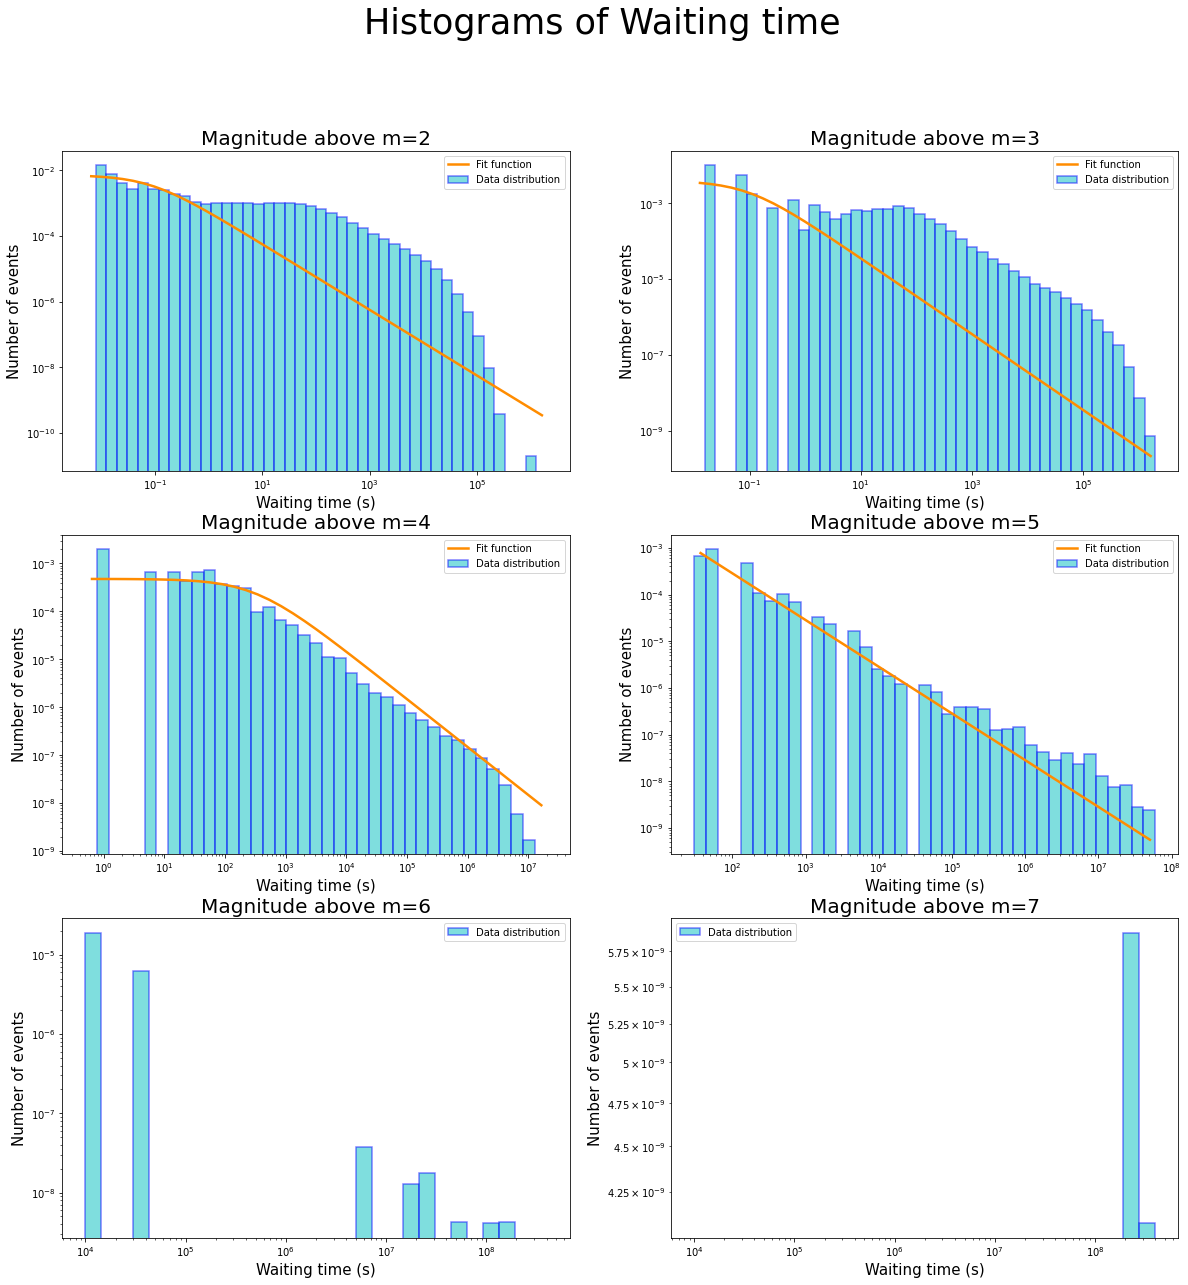

In [145]:
#Distribution of waiting times for magnitude m or above

fig, ((ax1, ax2),(bx1, bx2),(cx1, cx2)) = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
fig.suptitle('Histograms of Waiting time', fontsize=35)

#lists for histograms
bin_list = [np.logspace(np.log10(5*10**(-3)), np.log10(2*10**6), 45), np.logspace(np.log10(10**(-2)),np.log10(2*10**6), 45),
            np.logspace(np.log10(0.5), np.log10(2*10**7), 40), np.logspace(np.log10(30),np.log10(6*10**7), 40),
            np.logspace(np.log10(10**4), np.log10(4*10**8), 30), np.logspace(np.log10(10**4), np.log10(4*10**8), 30)]
m_list = [i for i in range(2,8,1)]
plot_list = [ax1, ax2, bx1, bx2, cx1, cx2]

for b,m,p in zip(bin_list, m_list, plot_list):
    
    #select events with m or above magnitude
    mask = df['mag'] >= m
    dt = df['t'][mask].diff().dropna(how='any')
    
    #histogram of waiting time
    n, bins, patches = p.hist(dt, bins = b, alpha = 0.5, color = 'c', edgecolor='b', 
                              label = 'Data distribution', density=True, histtype='bar', linewidth=1.5)
    p.set_xscale('log')
    p.set_yscale('log')
    p.set_title('Magnitude above m=' + str(m), fontsize=20)
    p.set_xlabel('Waiting time (s)', fontsize=15)
    p.set_ylabel('Number of events', fontsize=15)
    #p.grid(True, linestyle="--", linewidth=0.5, color='.25', axis='y')
    
    #fit the distribution (sistemare)
    if m < 6 :
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        #xspace = np.linspace(binscenters[0], binscenters[-1], 100)
        par, pcov = curve_fit(fit_pdf, xdata=binscenters, ydata=n, p0=[100, 0])
        print("Distribution model with m=%0.0f:   P(t) = %0.4f/(t + %0.4f)" %(m, par[0], abs(par[1]))) 
        
        p.plot(binscenters, fit_pdf(binscenters, *par), color='darkorange', linewidth=2.5, label='Fit function')
        
    p.legend()

Distribution model with m=2 of group 0:   P(t) = 0.025/(t + 6.228)
Distribution model with m=2 of group 39805:   P(t) = 0.330/(t + 375.621)


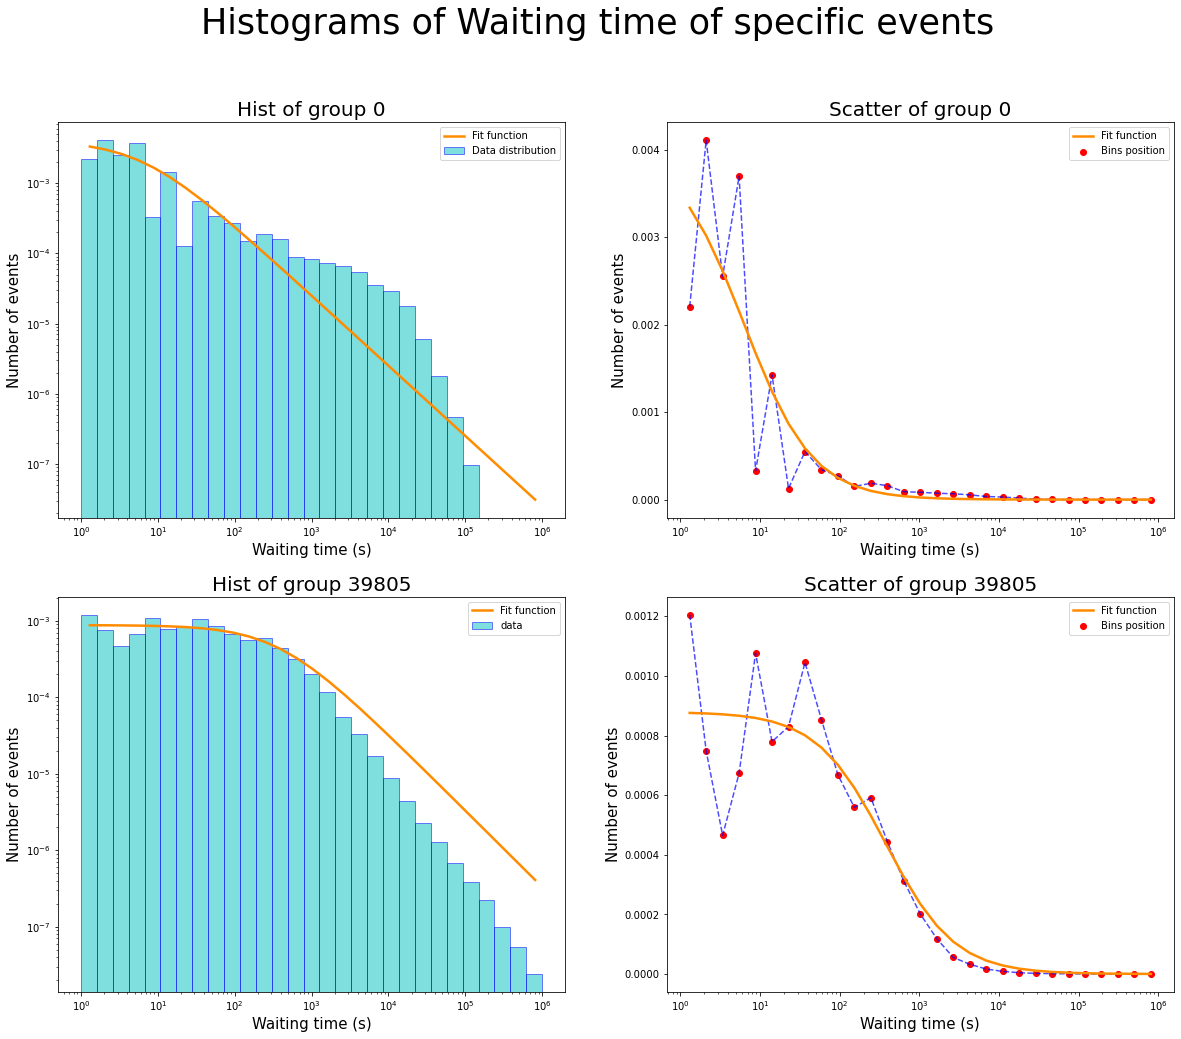

In [149]:
#Histograms of some groups of concatenated events

fig, ((ax1, ax2),(bx1, bx2)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))
fig.suptitle('Histograms of Waiting time of specific events', fontsize=35)


#creating an event column to connect events with same pointer 0
df['event'] = df['pointer'].where(df['pointer'] != -1, df['index'])
df_g = df[df['event'] == 0]

m = 2
mask = df_g['mag'] >= m
dt = df_g['t'][mask].diff().dropna(how='any')

#histograms of waiting time  
n, bins, patches = ax1.hist(dt, bins=np.logspace(np.log10(1), np.log10(10**6), 30), alpha = 0.5, color = 'c', edgecolor='b', 
                            label = 'Data distribution', density=True)
ax1.set_title('Hist of group 0', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Waiting time (s)', fontsize=15)
ax1.set_ylabel('Number of events', fontsize=15)

#fit of hist
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
par, pcov = curve_fit(fit_pdf, xdata=binscenters, ydata=n, p0=[0.01, 0])
print("Distribution model with m=%0.0f of group 0:   P(t) = %0.3f/(t + %0.3f)" %(m, par[0], abs(par[1])))      
ax1.plot(binscenters, fit_pdf(binscenters, *par), color='darkorange', linewidth=2.5, label='Fit function')
ax1.legend()

#second plot
ax2.scatter(binscenters, n, color='r', label='Bins position')
ax2.plot(binscenters, n, color='b', linestyle='--', alpha=0.7)
ax2.plot(binscenters, fit_pdf(binscenters, *par), color='darkorange', linewidth=2.5, label='Fit function')

ax2.set_title('Scatter of group 0', fontsize=20)
ax2.set_xscale('log')
ax2.set_xlabel('Waiting time (s)', fontsize=15)
ax2.set_ylabel('Number of events', fontsize=15)
ax2.legend()

#creating an event column to connect events with same pointer 39805
df['event'] = df['pointer'].where(df['pointer'] != -1, df['index'])
df_g = df[df['event'] == 39805]

m = 2
mask = df_g['mag'] >= m
dt = df_g['t'][mask].diff().dropna(how='any')

#histograms of waiting time  
n, bins, patches = bx1.hist(dt, bins=np.logspace(np.log10(1), np.log10(10**6), 30), alpha = 0.5, color = 'c', edgecolor='b', 
                            label = 'data', density=True)
bx1.set_title('Hist of group 39805', fontsize=20)
bx1.set_xscale('log')
bx1.set_yscale('log')
bx1.set_xlabel('Waiting time (s)', fontsize=15)
bx1.set_ylabel('Number of events', fontsize=15)

#fit of hist
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
par, pcov = curve_fit(fit_pdf, xdata=binscenters, ydata=n, p0=[0.1, 0])
print("Distribution model with m=%0.0f of group 39805:   P(t) = %0.3f/(t + %0.3f)" %(m, par[0], abs(par[1])))      
bx1.plot(binscenters, fit_pdf(binscenters, *par), color='darkorange', linewidth=2.5, label='Fit function')
bx1.legend()

#second plot
bx2.scatter(binscenters, n, color='r', label='Bins position')
bx2.plot(binscenters, n, color='b', linestyle='--', alpha=0.7)
bx2.plot(binscenters, fit_pdf(binscenters, *par), color='darkorange', linewidth=2.5, label='Fit function')

bx2.set_title('Scatter of group 39805', fontsize=20)
bx2.set_xscale('log')
bx2.set_xlabel('Waiting time (s)', fontsize=15)
bx2.set_ylabel('Number of events', fontsize=15)
bx2.legend()

count    110271.000000
mean      54118.079241
std       31671.155960
min           0.000000
25%       27300.000000
50%       53481.000000
75%       82122.500000
max      110270.000000
Name: event, dtype: float64


Text(0.5, 1.0, 'Events')

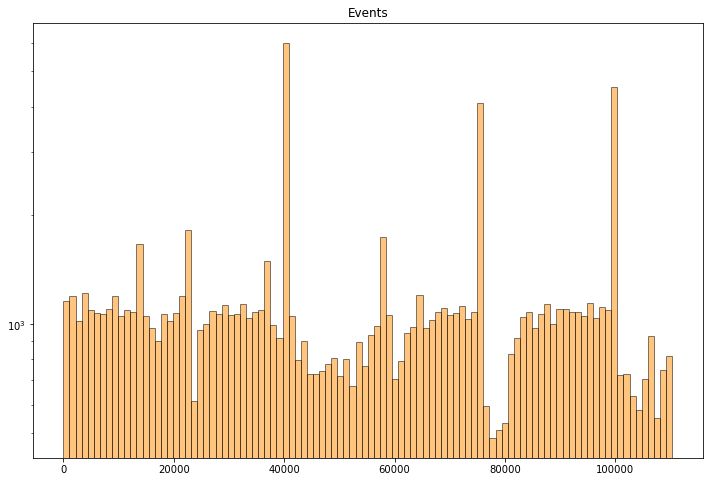

In [8]:
print(df['event'].describe())
plt.figure(figsize=(12,8))
plt.hist(df['event'], bins=100, alpha = 0.5, color = 'darkorange', edgecolor='black')
plt.yscale('log')
plt.title('Events')

#75422
#39805

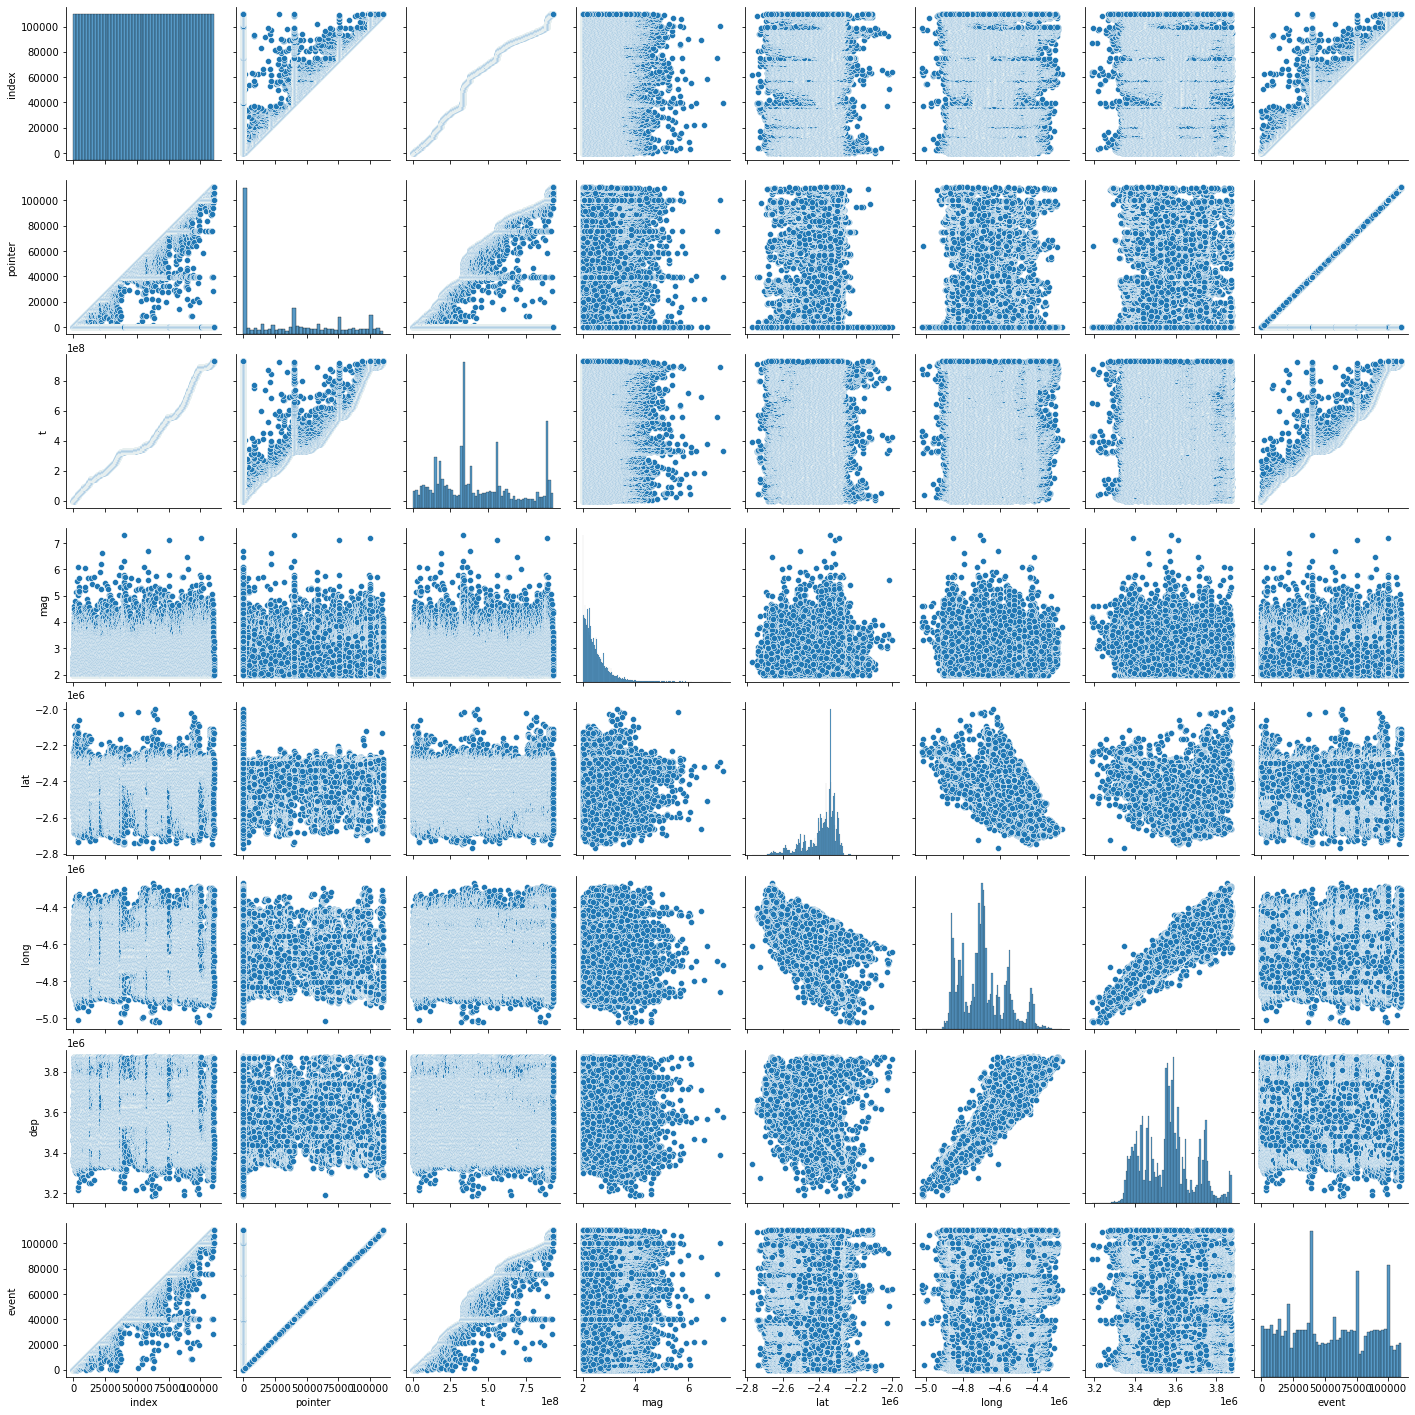

In [9]:
sns.pairplot(df)

In [147]:
import ipywidgets as widgets
from ipywidgets import interactive
from scipy import stats

def histo(m, b,c,ed):
    plt.figure(figsize=(12,8))
    mask = df['mag'] >= m
    dt = df['t'][mask].diff().dropna(how='any')
    print(dt.describe())
    
    bin_list = [np.logspace(np.log10(5*10**(-3)), np.log10(2*10**6), b), np.logspace(np.log10(10**(-2)),np.log10(2*10**6), b),
            np.logspace(np.log10(0.5), np.log10(2*10**7), b), np.logspace(np.log10(30),np.log10(6*10**7), b),
            np.logspace(np.log10(10**4), np.log10(4*10**8), b), np.logspace(np.log10(10**4), np.log10(4*10**8), b)]
    
    #histogram of waiting time
    bi = bin_list[m-2]
    n, bins, patches = plt.hist(dt, bins = bi, alpha = 0.5, 
             color = c, edgecolor=ed, label = 'Data distribution', density=True, histtype='bar', linewidth=1, zorder=1)
    
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    plt.scatter(binscenters, n, color='r', label='Bins position', zorder=3)
    plt.plot(binscenters, n, color='r', linestyle='--', alpha=0.7, zorder=2)
    
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    par, pcov = curve_fit(fit_pdf, xdata=binscenters, ydata=n, p0=[100, 0])
    print("\nDistribution model with m=%0.0f:   P(t) = %0.4f/(t + %0.4f)" %(m, par[0], abs(par[1]))) 
    plt.plot(binscenters, fit_pdf(binscenters, *par), color='darkorange', linewidth=2.5, label='Fit function')
    
    #stats.chisquare(fit_pdf)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Magnitude above m=%0.0f and nbins=%0.0f' %(m, b) , fontsize=20)
    plt.xlabel('Waiting time (s)', fontsize=15)
    plt.ylabel('Number of events', fontsize=15)
    plt.legend()
    plt.show()

interactive_plot = interactive(histo, m=(2, 7, 1), b=(10,100,5), c=['red', 'blue', 'cyan', 'orange', 'yellow', 'green', 'black'], 
                               ed=['red', 'blue', 'cyan', 'orange', 'yellow', 'green', 'black'])
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(IntSlider(value=4, description='m', max=7, min=2), IntSlider(value=55, description='b', …

In [148]:
def histo2(m, b, eve,c,ed):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
    fig.suptitle('Histograms of Waiting time of specific events', fontsize=25)
    
    df['event'] = df['pointer'].where(df['pointer'] != -1, df['index'])
    df_g = df[df['event'] == eve]
    mask = df_g['mag'] >= m
    dt = df_g['t'][mask].diff().dropna(how='any')
    print('Description of all event set:\n', df['event'].describe(), '\n')
    print('Description of this event set:\n', dt.describe())
    
    bin_list = [np.logspace(np.log10(5*10**(-3)), np.log10(2*10**6), b), np.logspace(np.log10(10**(-2)),np.log10(2*10**6), b),
            np.logspace(np.log10(0.5), np.log10(2*10**7), b), np.logspace(np.log10(30),np.log10(6*10**7), b),
            np.logspace(np.log10(10**4), np.log10(4*10**8), b), np.logspace(np.log10(10**4), np.log10(4*10**8), b)]
    
    #histogram of waiting time
    bi = bin_list[m-2]
    n, bins, patches = ax1.hist(dt, bins = bi, alpha = 0.5, 
             color = c, edgecolor=ed, label = 'Data distribution', density=True)
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title('Magnitude above m=%0.0f, nbins=%0.0f for the event nr. %0.0f' %(m, b, eve) , fontsize=20)
    ax1.set_xlabel('Waiting time (s)', fontsize=15)
    ax1.set_ylabel('Number of events', fontsize=15)
        
    #scatter plot
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    ax2.scatter(binscenters, n, color='r', label='Bins position')
    ax2.plot(binscenters, n, color='b', linestyle='--', alpha=0.7)
    
    ax2.set_title('Scatter of group: ' +str(eve), fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlabel('Waiting time (s)', fontsize=15)
    ax2.set_ylabel('Number of events', fontsize=15)
    ax2.legend()

interactive_plot = interactive(histo2, m=(2, 7, 1), b=(10,100,5), eve=(0,100000,500), 
                               c=['red', 'blue', 'cyan', 'orange', 'yellow', 'green', 'black'], 
                               ed=['red', 'blue', 'cyan', 'orange', 'yellow', 'green', 'black'])
output = interactive_plot.children[-1]
output.layout.height = '830px'
interactive_plot

interactive(children=(IntSlider(value=4, description='m', max=7, min=2), IntSlider(value=55, description='b', …